In [1]:
import matplotlib.pyplot as plt
import rasterio.plot

In [2]:
plt.rcParams["figure.figsize"] = [10,8]  # Set default figure size
%config InlineBackend.figure_format = 'retina'

## Handler

In [3]:
import geopandas as gpd
import rasterio
from shapely.geometry import Point

precision = 5 # precision of input coordinates, 5dec~=1.1m

class GISHandler:
    """A class to handle GIS raster data and optimizer points."""
        
    def __init__(self, files):
        """Initializes handler by creating a GeoDataFrame to store point measurement data and a dictionary of loaded raster files."""
        self.rasters = {}
        self.points = gpd.GeoDataFrame(columns=['x', 'y', 'valid', 'result', 'geometry'], geometry='geometry')
        
        for key, src in files.items():
            if key in self.rasters:
                print('raster {} already loaded!'.format(key))
            else:
                self.rasters[key] = rasterio.open(src)
                
        self.extent = self.extent()
    
    def query(self, y, x):
        """Gets condition data for a specified geography location (lon/lat), stores it in the GeoDataFrame, and returns the row."""
        x, y = self.coordinate(x, y)
                                    
        if not self.points.loc[(self.points.x==x) & (self.points.y==y)].empty:
            print('point exists, returning original data')
            return self.points.loc[(self.points.x==x) & (self.points.y==y)]
        
        conditions = {'x': x, 'y': y, 'valid': True, 'geometry': Point(x, y)}
        
        for key, raster in self.rasters.items():
            index = raster.index(x, y)
            try:
                 conditions[key] = raster.read(1)[index] # yes, by default this only reads the first band, but this is probably okay
            except IndexError as error:
                print('failed to read {} raster: {}'.format(key, error))
            if conditions[key] <= 0: # yes, this assumes that zero is not a valid value. this is true for our current rasters, but isn't neccsarily correct
                conditions['valid'] = False
        
        self.points = self.points.append(conditions, ignore_index=True)
        return self.points.iloc[-1:]
    
    def record(self, y, x, value):
        """Records a computed value from the optimizer to a geographic point, returns row recorded to."""
        x, y = self.coordinate(x, y)
        
        if not self.points.loc[(self.points.x==x) & (self.points.y==y)].empty:
            self.points.loc[(self.points.x==x) & (self.points.y==y), 'result'] = value
            return self.points.loc[(self.points.x==x) & (self.points.y==y)]
        
        conditions = {'x': x, 'y': y, 'geometry': Point(x, y), 'result': value}
        self.points = self.points.append(conditions, ignore_index=True)
        return self.points.iloc[-1:]       
        
    def coordinate(self, x, y):
        """Rounds coordinates to given precision to prevent uneccessary duplication, in the future could handle projections."""
        return round(x, precision), round(y, precision)
    
    def extent(self):
        """Calculates largest square extent that includes data from all loaded rasters."""
        
        extent = [-180, 180, -90, 90] # format: [W, E, S, N]
        for src in self.rasters.values():
            extent = [max(extent[0], src.bounds[0]), min(extent[1], src.bounds[2]), max(extent[2], src.bounds[1]), min(extent[3], src.bounds[3])]
            
        return extent

## Example

In [4]:
raster_files = {'current [m/s]': 'data/Surface Current (m-s).tif',
                'oxygen [mg/l]': 'data/Surface Oxygen (mg-l).tif',
                'salinity [PSU]': 'data/Surface Salinity (PSU).tif',
                'temperature [°C]': 'data/Surface Temperature (C).tif',
                'period [s]': 'data/Wave Energy Period (s).tif',
                'power [kW/m]': 'data/Wave Power Density (kW-m).tif',
                'height [m]': 'data/Wave Significant Height (m).tif',
                'distance to port [m]': 'data/Distance to Port (m).tif',
                'distance to shore [m]': 'data/Distance to Shore (m).tif'}

handler = GISHandler(raster_files)

In [5]:
print('Extent: W', handler.extent[0], 'E', handler.extent[1], 'S', handler.extent[2], 'N', handler.extent[3])

Extent: W -75.105000333 E -65.695000333 S 38.269566058 N 45.195711428


In [6]:
handler.query(40.932999, -72)

/usr/local/anaconda3/envs/geo-venv/lib/python3.7/site-packages/pandas/core/dtypes/cast.py:118: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  arr = construct_1d_object_array_from_listlike(values)


,x,y,valid,result,geometry,current [m/s],distance to port [m],distance to shore [m],height [m],oxygen [mg/l],period [s],power [kW/m],salinity [PSU],temperature [°C]
0,-72,40.933,True,NaN,POINT (-72.00000 40.93300),0.028161,86523.117188,5700.876953,1.07,9.211792,6.01,5.1,30.667662,12.029641


In [7]:
handler.record(40.932999, -72, 10)

,x,y,valid,result,geometry,current [m/s],distance to port [m],distance to shore [m],height [m],oxygen [mg/l],period [s],power [kW/m],salinity [PSU],temperature [°C]
0,-72,40.933,True,10.0,POINT (-72.00000 40.93300),0.028161,86523.117188,5700.876953,1.07,9.211792,6.01,5.1,30.667662,12.029641


In [8]:
handler.query(40, -68)
handler.points

/usr/local/anaconda3/envs/geo-venv/lib/python3.7/site-packages/pandas/core/dtypes/cast.py:118: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  arr = construct_1d_object_array_from_listlike(values)


,x,y,valid,result,geometry,current [m/s],distance to port [m],distance to shore [m],height [m],oxygen [mg/l],period [s],power [kW/m],salinity [PSU],temperature [°C]
0,-72,40.933,True,10.0,POINT (-72.00000 40.93300),0.028161,86523.117188,5700.876953,1.07,9.211792,6.01,5.1,30.667662,12.029641
1,-68,40.000,False,NaN,POINT (-68.00000 40.00000),0.096250,327133.750000,216772.343750,0.00,8.605487,0.00,0.0,34.263721,15.900171


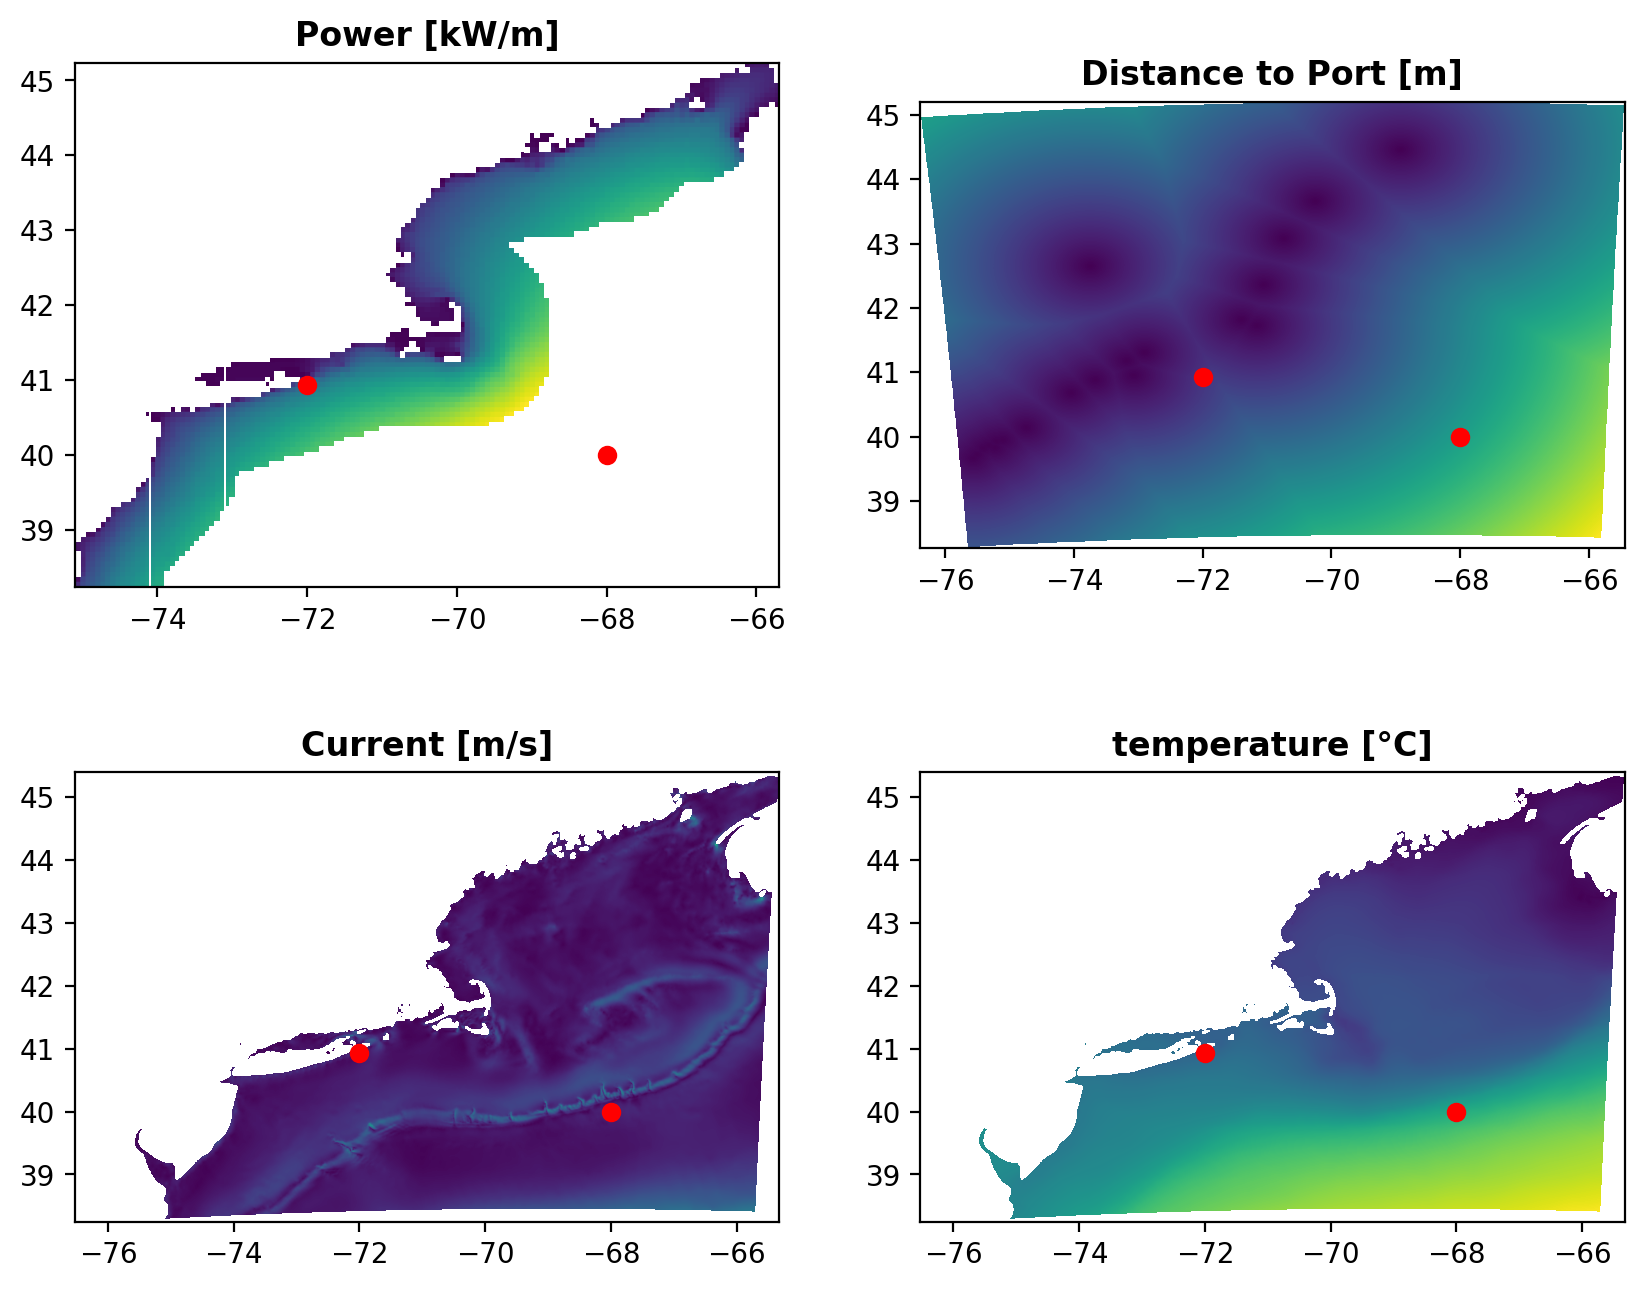

In [9]:
fig, ax = plt.subplots(2, 2)
rasterio.plot.show(handler.rasters['power [kW/m]'], ax=ax[0,0], title='Power [kW/m]')
rasterio.plot.show(handler.rasters['distance to port [m]'], ax=ax[0,1], title='Distance to Port [m]')
rasterio.plot.show(handler.rasters['current [m/s]'], ax=ax[1,0], title='Current [m/s]')
rasterio.plot.show(handler.rasters['temperature [°C]'], ax=ax[1,1], title='temperature [°C]')

for i in ax:
    for j in i:
        handler.points.plot(ax=j, color='red')